In [204]:
%matplotlib inline

In [1]:
from catboost import Pool, CatBoostRegressor, cv

In [2]:
from sklearn.neural_network import MLPRegressor

In [196]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
import itertools

In [64]:
from sklearn.preprocessing import QuantileTransformer

In [65]:
from sklearn.compose import TransformedTargetRegressor

In [236]:
data_all = pd.read_csv('lab_dataset_isolated.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,13.008867,4.997579,6.588583,0.526244,0.203860,0.269896,24.545291,2.822392,0.978304,1.805997,...,1.640288,0.666432,1.253505,15.278301,0.700631,0.999954,1,1,1,10
1,6.609362,3.189992,5.576801,0.421152,0.211133,0.367715,15.238694,-0.296128,0.806050,2.021186,...,1.651874,0.741170,1.449528,15.278150,0.751461,0.999924,1,1,2,10
2,4.543573,2.450310,5.857017,0.348217,0.193641,0.458142,12.801766,0.110082,-0.123097,2.276599,...,1.654976,0.649358,1.179714,15.278049,0.650021,0.999934,1,1,3,10
3,9.122896,5.277992,7.450680,0.414250,0.247133,0.338618,21.968466,0.975603,1.584207,2.926163,...,1.640274,0.670234,1.247952,15.277748,0.640363,1.000000,1,1,4,10
4,12.466345,7.668964,7.305215,0.455908,0.279164,0.264928,27.811060,0.867278,2.583827,1.179988,...,1.621492,0.635067,1.139174,15.278251,0.710897,0.999888,1,1,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,8.720496,3.851477,9.021509,0.410116,0.176919,0.412965,21.800934,1.107516,-2.193685,0.777071,...,1.542705,0.385582,0.544647,15.586546,0.451471,0.999797,12,8,14,2
1572,6.408689,3.310907,9.966467,0.326135,0.169916,0.503949,19.780738,0.355814,-1.368689,2.422212,...,1.558130,0.443621,0.607946,15.586709,0.461571,0.999650,12,8,15,2
1573,3.515711,2.250204,10.708599,0.216626,0.135352,0.648022,16.726009,-1.599358,-0.663121,4.998161,...,1.548392,0.453187,0.541683,15.586424,0.449059,0.999922,12,8,16,2
1574,4.500857,2.437937,12.810566,0.228281,0.121847,0.649872,19.760628,0.172997,-0.698937,6.929964,...,1.565545,0.478419,0.722761,15.586668,0.458831,0.999912,12,8,17,2


In [237]:
X = data_all.drop(['film', 'labels', 'Subj'], axis=1)
y = data_all['labels']
X

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,PSDslope,RR,SDA,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,ch
0,13.008867,4.997579,6.588583,0.526244,0.203860,0.269896,24.545291,2.822392,0.978304,1.805997,...,3.028399,0.169745,0.746456,1.640288,0.666432,1.253505,15.278301,0.700631,0.999954,1
1,6.609362,3.189992,5.576801,0.421152,0.211133,0.367715,15.238694,-0.296128,0.806050,2.021186,...,3.009936,0.263701,0.748870,1.651874,0.741170,1.449528,15.278150,0.751461,0.999924,2
2,4.543573,2.450310,5.857017,0.348217,0.193641,0.458142,12.801766,0.110082,-0.123097,2.276599,...,3.169472,0.153315,0.704845,1.654976,0.649358,1.179714,15.278049,0.650021,0.999934,3
3,9.122896,5.277992,7.450680,0.414250,0.247133,0.338618,21.968466,0.975603,1.584207,2.926163,...,2.984443,0.173577,0.715325,1.640274,0.670234,1.247952,15.277748,0.640363,1.000000,4
4,12.466345,7.668964,7.305215,0.455908,0.279164,0.264928,27.811060,0.867278,2.583827,1.179988,...,2.977384,0.140812,0.684273,1.621492,0.635067,1.139174,15.278251,0.710897,0.999888,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,8.720496,3.851477,9.021509,0.410116,0.176919,0.412965,21.800934,1.107516,-2.193685,0.777071,...,3.216964,0.026419,0.697177,1.542705,0.385582,0.544647,15.586546,0.451471,0.999797,14
1572,6.408689,3.310907,9.966467,0.326135,0.169916,0.503949,19.780738,0.355814,-1.368689,2.422212,...,3.161934,0.040831,0.595713,1.558130,0.443621,0.607946,15.586709,0.461571,0.999650,15
1573,3.515711,2.250204,10.708599,0.216626,0.135352,0.648022,16.726009,-1.599358,-0.663121,4.998161,...,3.258573,0.043685,0.522241,1.548392,0.453187,0.541683,15.586424,0.449059,0.999922,16
1574,4.500857,2.437937,12.810566,0.228281,0.121847,0.649872,19.760628,0.172997,-0.698937,6.929964,...,3.219369,0.052076,0.675380,1.565545,0.478419,0.722761,15.586668,0.458831,0.999912,17


In [238]:
group_kfold = GroupKFold(n_splits=12)
gkf = group_kfold.get_n_splits(X, y, data_all['Subj'])

In [248]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [267]:
numeric_columns = [
       'Theta', 'Alpha', 'Beta', 'Theta_ratio', 'Alpha_ratio', 'Beta_ratio',
       'TotalAbsPow', 'Theta_watch-relax', 'Alpha_watch-relax',
       'Beta_watch-relax', 'Beta/Alpha', 'Beta/(Alpha + Theta)', 'ApEn',
       'CREn', 'DiffEn', 'FI', 'Hjorth', 'Hurst', 'KFD', 'LZC', 'MSE', 'MSPEn',
       'NLD', 'PEn', 'PFD', 'PLZC', 'PSDslope', 'RR', 'SDA', 'SFD', 'SVDEn',
       'SampEn', 'ShanEn', 'SpEn', 'WPEn'
]
categorical_columns = ['ch']

In [268]:
column_transformer = ColumnTransformer(
     transformers=[
      ('categories', OneHotEncoder(dtype='int'), categorical_columns),
      ('scaler', PowerTransformer(), numeric_columns)]
)

In [269]:
pipeline = Pipeline(
    steps=[("column_transformer", column_transformer), ("regressor", MLPRegressor())]
)

In [272]:
model = TransformedTargetRegressor(regressor=pipeline, transformer=QuantileTransformer(output_distribution='normal'))

In [273]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=gkf, n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    3.0s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    4.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.8s finished


In [274]:
scores

array([-3.5053435 , -2.98116167, -3.12265929, -3.01587125, -3.13086925,
       -3.52609411, -3.42209151, -3.35115836, -3.78060937, -4.09874587,
       -3.05198067, -3.41717517])

In [275]:
from numpy import mean
from numpy import absolute

In [276]:
scores = absolute(scores)
# summarize the result
s_mean = mean(scores)
print('Mean RMSE: %.3f' % (s_mean))

Mean RMSE: 3.367


In [279]:
params = {'regressor__regressor__activation': ['relu', 'tanh', 'logistic', 'identity'],
          'regressor__regressor__hidden_layer_sizes': list(itertools.permutations([50,100,150], 2)) + list(itertools.permutations([50,100,150], 3)) + [50, 100, 150],
          'regressor__regressor__solver': ['adam', 'lbfgs'],
          'regressor__regressor__learning_rate' : ['constant', 'adaptive', 'invscaling']
         }

In [ ]:
grid = GridSearchCV(model, params, cv=gkf, n_jobs=-1, verbose=4).fit(X, y, groups=data_all['Subj'])

In [281]:
grid.best_params_

{'regressor__activation': 'relu',
 'regressor__alpha': 0.0001,
 'regressor__hidden_layer_sizes': (100, 50, 30),
 'regressor__learning_rate': 'constant',
 'regressor__max_iter': 200,
 'regressor__solver': 'sgd'}

In [325]:
params = {
 'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100, 50, 30),
 'learning_rate': 'constant',
 'max_iter': 200,
 'solver': 'sgd',
 'early_stopping' : True,
 'max_iter' : 1000
}

In [327]:
X_test = data_all.loc[(data_all['film']  == 8)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 8)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'labels', 'Subj'], axis=1)
X_test = X_test.drop(['film', 'labels', 'Subj'], axis=1)

In [328]:
column_transformer = ColumnTransformer(
     transformers=[
      ('categories', OneHotEncoder(dtype='int'), categorical_columns),
      ('scaler', PowerTransformer(), numeric_columns)]
)

In [329]:
pipeline = Pipeline(
    steps=[("column_transformer", column_transformer), ("regressor", MLPRegressor(**params))]
)

In [330]:
model = TransformedTargetRegressor(regressor=pipeline, transformer=QuantileTransformer(output_distribution='normal'))

In [314]:
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=gkf, n_jobs=-1, verbose=4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    5.1s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    8.1s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.2s finished


In [315]:
scores = absolute(scores)
# summarize the result
s_mean = mean(scores)
print('Mean RMSE: %.3f' % (s_mean))

Mean RMSE: 3.064


In [331]:
model.fit(X_train, y_train)

overflow encountered in multiply
overflow encountered in reduce
divide by zero encountered in log


TransformedTargetRegressor(regressor=Pipeline(steps=[('column_transformer',
                                                      ColumnTransformer(transformers=[('categories',
                                                                                       OneHotEncoder(dtype='int'),
                                                                                       ['ch']),
                                                                                      ('scaler',
                                                                                       PowerTransformer(),
                                                                                       ['Theta',
                                                                                        'Alpha',
                                                                                        'Beta',
                                                                                        'Theta_ratio',
               

In [332]:
preds = model.predict(X_test)
preds

array([ 4.        ,  7.        ,  5.        ,  2.        ,  1.        ,
        8.        ,  8.        ,  9.        ,  7.        ,  7.        ,
        9.        ,  1.        , 10.        ,  5.        ,  7.        ,
        9.        ,  6.        ,  5.        ,  9.        ,  5.        ,
        5.        ,  3.        , 10.        ,  6.87251201,  8.        ,
        3.        ,  3.        ,  4.        ,  7.        ,  1.        ,
        7.        ,  6.        ,  4.        ,  3.        ,  9.        ,
        9.        ,  8.        ,  9.        ,  2.        ,  3.        ,
        2.        ,  7.        ,  4.        ,  7.        ,  1.        ,
        5.        ,  8.        ,  6.        ,  5.        ,  8.        ,
        7.        ,  1.        , 10.        ,  4.        ,  4.        ,
        8.        ,  8.        ,  9.        ,  5.        ,  4.        ,
        7.        ,  4.        ,  9.        ,  9.        ,  5.        ,
        5.        ,  1.        ,  3.        ,  3.        ,  3.  

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

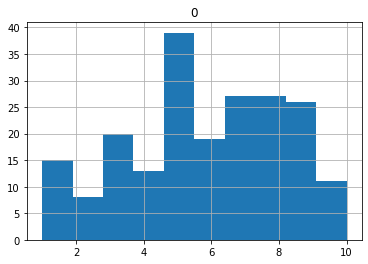

In [333]:
pd.DataFrame(preds).hist()

In [334]:
pd.DataFrame(preds).describe()

,0
count,205.000000
mean,5.857719
std,2.538461
min,1.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,10.000000


In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
n_subjects = 12
n_films = 8
pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
channels = [[] for i in range(n_subjects)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(n_films):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [336]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 9.00 predicted: 7.81 
label : 9.00 predicted: 8.11 
label : 2.00 predicted: 3.17 
label : 6.00 predicted: 7.56 
label : 2.00 predicted: 2.00 
label : 5.00 predicted: 5.77 
label : 5.00 predicted: 8.69 
label : 7.00 predicted: 6.78 
label : 9.00 predicted: 5.22 
label : 2.00 predicted: 4.72 
label : 4.00 predicted: 4.72 
label : 2.00 predicted: 6.06 


In [337]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [338]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.3432180556130425
MAPE: 0.49880864658389723
MAE :  1.7294801221034115


## Таблица со значениями метрик

In [339]:
data_all = pd.read_csv('lab_dataset_isolated.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,13.008867,4.997579,6.588583,0.526244,0.203860,0.269896,24.545291,2.822392,0.978304,1.805997,...,1.640288,0.666432,1.253505,15.278301,0.700631,0.999954,1,1,1,10
1,6.609362,3.189992,5.576801,0.421152,0.211133,0.367715,15.238694,-0.296128,0.806050,2.021186,...,1.651874,0.741170,1.449528,15.278150,0.751461,0.999924,1,1,2,10
2,4.543573,2.450310,5.857017,0.348217,0.193641,0.458142,12.801766,0.110082,-0.123097,2.276599,...,1.654976,0.649358,1.179714,15.278049,0.650021,0.999934,1,1,3,10
3,9.122896,5.277992,7.450680,0.414250,0.247133,0.338618,21.968466,0.975603,1.584207,2.926163,...,1.640274,0.670234,1.247952,15.277748,0.640363,1.000000,1,1,4,10
4,12.466345,7.668964,7.305215,0.455908,0.279164,0.264928,27.811060,0.867278,2.583827,1.179988,...,1.621492,0.635067,1.139174,15.278251,0.710897,0.999888,1,1,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,8.720496,3.851477,9.021509,0.410116,0.176919,0.412965,21.800934,1.107516,-2.193685,0.777071,...,1.542705,0.385582,0.544647,15.586546,0.451471,0.999797,12,8,14,2
1572,6.408689,3.310907,9.966467,0.326135,0.169916,0.503949,19.780738,0.355814,-1.368689,2.422212,...,1.558130,0.443621,0.607946,15.586709,0.461571,0.999650,12,8,15,2
1573,3.515711,2.250204,10.708599,0.216626,0.135352,0.648022,16.726009,-1.599358,-0.663121,4.998161,...,1.548392,0.453187,0.541683,15.586424,0.449059,0.999922,12,8,16,2
1574,4.500857,2.437937,12.810566,0.228281,0.121847,0.649872,19.760628,0.172997,-0.698937,6.929964,...,1.565545,0.478419,0.722761,15.586668,0.458831,0.999912,12,8,17,2


In [340]:
from tqdm import tqdm_notebook

In [341]:
models = ['MLPRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [342]:
numeric_columns = [
       'Theta', 'Alpha', 'Beta', 'Theta_ratio', 'Alpha_ratio', 'Beta_ratio',
       'TotalAbsPow', 'Theta_watch-relax', 'Alpha_watch-relax',
       'Beta_watch-relax', 'Beta/Alpha', 'Beta/(Alpha + Theta)', 'ApEn',
       'CREn', 'DiffEn', 'FI', 'Hjorth', 'Hurst', 'KFD', 'LZC', 'MSE', 'MSPEn',
       'NLD', 'PEn', 'PFD', 'PLZC', 'PSDslope', 'RR', 'SDA', 'SFD', 'SVDEn',
       'SampEn', 'ShanEn', 'SpEn', 'WPEn'
]
categorical_columns = ['ch']

In [344]:
result = pd.DataFrame()
grid_res = []
n_films = 8
n_subjects = 12
for film in tqdm_notebook(range(1, n_films + 1)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels'], axis=1)
    
    column_transformer = ColumnTransformer(
     transformers=[
      ('categories', OneHotEncoder(dtype='int'), categorical_columns),
      ('scaler', PowerTransformer(), numeric_columns)]
    )
    
    pipeline = Pipeline(
    steps=[("column_transformer", column_transformer), ("regressor", MLPRegressor(**params))]
    )
    model = TransformedTargetRegressor(regressor=pipeline, transformer=QuantileTransformer(output_distribution='normal'))
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    df[('MLPRegressor', 'R2', 'inverted')] = r2_score(preds, y_test)
    df[('MLPRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test)
    df[('MLPRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test)
    
    pred = [[0 for j in range(n_films)] for i in range(n_subjects)]
    num_chans = [[0 for j in range(n_films)] for i in range(n_subjects)]
    labels = [[0 for j in range(n_films)] for i in range(n_subjects)]
    lbl = [[0 for j in range(n_films)] for i in range(n_subjects)]
    channels = [[] for i in range(n_subjects)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(n_films):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('MLPRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('MLPRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('MLPRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

overflow encountered in multiply
overflow encountered in reduce
divide by zero encountered in log
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered in multiply
overflow encountered in reduce
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered in multiply
overflow encountered in reduce
divide by zero encountered in log
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered in multiply
overflow encountered in reduce
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered in multiply
overflow encountered in reduce
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered in multiply
overflow encountered in reduce
divide by zero encountered in log
invalid value encountered in true_divide
invalid value encountered in true_divide
overflow encountered i

In [345]:
result

MLPRegressor                                                  
          MAPE                 MAE                  R2          
      inverted   average  inverted   average  inverted   average
0     0.853647  0.440221  2.958778  2.722077 -0.792873 -0.647310
0     0.775643  0.565298  2.814108  2.679432 -1.195925 -0.568485
0     0.727195  0.720770  2.769173  2.235264 -0.545283 -1.668694
0     0.937681  0.662658  3.260127  3.090920 -1.821616 -0.510631
0     0.343491  1.045355  2.936560  2.601573 -3.401656 -0.867037
0     0.443836  0.537623  2.192572  1.938469 -0.434575 -0.114403
0     0.497131  0.458758  2.474732  2.056729 -0.506497 -1.029604
0     0.445263  0.543023  2.210549  1.924947 -0.399027  0.154031

In [347]:
result.to_excel('metrics_MLP_lab4.xlsx')

In [192]:
result.describe()

MLPRegressor                                                   
              MAPE                 MAE                   R2          
          inverted   average  inverted   average   inverted   average
count     8.000000  8.000000  8.000000  8.000000   8.000000  8.000000
mean      0.384564  0.590279  2.170900  2.165646 -17.138502 -0.211484
std       0.097223  0.189331  0.481959  0.445512   7.915217  0.323753
min       0.208973  0.306508  1.223969  1.273997 -28.612673 -0.906902
25%       0.330560  0.443948  1.937363  1.986650 -22.227553 -0.313928
50%       0.399370  0.631011  2.293239  2.263492 -17.651238 -0.075909
75%       0.457786  0.738278  2.557909  2.487712 -12.295381 -0.020788
max       0.498074  0.795423  2.597782  2.589296  -6.049282  0.095575

In [348]:
result.describe().to_excel('metrics_MLP_lab_described4.xlsx')

In [349]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

## Таблицы со значениями shap для всех фильмов (1 на тест, остальные на обучение)

In [350]:
data_all = pd.read_csv('lab_dataset_isolated.csv')
data_all

,Theta,Alpha,Beta,Theta_ratio,Alpha_ratio,Beta_ratio,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,...,SFD,SVDEn,SampEn,ShanEn,SpEn,WPEn,Subj,film,ch,labels
0,13.008867,4.997579,6.588583,0.526244,0.203860,0.269896,24.545291,2.822392,0.978304,1.805997,...,1.640288,0.666432,1.253505,15.278301,0.700631,0.999954,1,1,1,10
1,6.609362,3.189992,5.576801,0.421152,0.211133,0.367715,15.238694,-0.296128,0.806050,2.021186,...,1.651874,0.741170,1.449528,15.278150,0.751461,0.999924,1,1,2,10
2,4.543573,2.450310,5.857017,0.348217,0.193641,0.458142,12.801766,0.110082,-0.123097,2.276599,...,1.654976,0.649358,1.179714,15.278049,0.650021,0.999934,1,1,3,10
3,9.122896,5.277992,7.450680,0.414250,0.247133,0.338618,21.968466,0.975603,1.584207,2.926163,...,1.640274,0.670234,1.247952,15.277748,0.640363,1.000000,1,1,4,10
4,12.466345,7.668964,7.305215,0.455908,0.279164,0.264928,27.811060,0.867278,2.583827,1.179988,...,1.621492,0.635067,1.139174,15.278251,0.710897,0.999888,1,1,6,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,8.720496,3.851477,9.021509,0.410116,0.176919,0.412965,21.800934,1.107516,-2.193685,0.777071,...,1.542705,0.385582,0.544647,15.586546,0.451471,0.999797,12,8,14,2
1572,6.408689,3.310907,9.966467,0.326135,0.169916,0.503949,19.780738,0.355814,-1.368689,2.422212,...,1.558130,0.443621,0.607946,15.586709,0.461571,0.999650,12,8,15,2
1573,3.515711,2.250204,10.708599,0.216626,0.135352,0.648022,16.726009,-1.599358,-0.663121,4.998161,...,1.548392,0.453187,0.541683,15.586424,0.449059,0.999922,12,8,16,2
1574,4.500857,2.437937,12.810566,0.228281,0.121847,0.649872,19.760628,0.172997,-0.698937,6.929964,...,1.565545,0.478419,0.722761,15.586668,0.458831,0.999912,12,8,17,2


In [351]:
import os

In [354]:
numeric_columns = [
       'Theta', 'Alpha', 'Beta', 'Theta_ratio', 'Alpha_ratio', 'Beta_ratio',
       'TotalAbsPow', 'Theta_watch-relax', 'Alpha_watch-relax',
       'Beta_watch-relax', 'Beta/Alpha', 'Beta/(Alpha + Theta)', 'ApEn',
       'CREn', 'DiffEn', 'FI', 'Hjorth', 'Hurst', 'KFD', 'LZC', 'MSE', 'MSPEn',
       'NLD', 'PEn', 'PFD', 'PLZC', 'PSDslope', 'RR', 'SDA', 'SFD', 'SVDEn',
       'SampEn', 'ShanEn', 'SpEn', 'WPEn'
]
categorical_columns = ['ch']

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
n_films = 8
for film in tqdm_notebook(range(1, n_films + 1)):
    if os.path.isfile('F{}_mlp_lab.png'.format(film)):
        continue
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film','ch', 'Subj', 'labels',], axis=1)
    X_test = X_test.drop(['film','ch', 'Subj', 'labels'], axis=1)
    model = MLPRegressor()
    model.fit(X_train, y_train)
    X_train_summary = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=23, show=False)
    plt.savefig('F{}_mlp_lab2.png'.format(film),  bbox_inches='tight')
    plt.clf()